# Fantasy Football Model
### Goal: create a model that uses player data from year x to predict fantasy points in year x + 1

In [1]:
!pip install pyopenssl ndg-httpsclient pyasn1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import traceback


In [2]:
## Calculates Fantasy points for each player in a dataframe
def fantasy_points(df):
  all_points = []
  for i,row in df.iterrows():
    player_points = 0
    player_points += 0.1 * (row['rush_yds'] + row['rec_yds'])
    player_points += 6 * (row['rush_td'] + row['rec_td'])
    player_points += (1/25) * row['pass_yds']
    player_points += (4) * row['pass_td']
    player_points += (-2) * row['int']
    player_points += (-2) * row['fumbles']
    ## No fumbles, no rush yards for wrs
    all_points.append(player_points)
  return all_points

In [3]:
# TAKEN FROM https://github.com/mjk2244/pro-football-reference-web-scraper/blob/main/pro_football_reference_web_scraper/player_game_log.py
# We found a bug in their source code, so just copying it to fix
import pandas as pd  # type: ignore
from bs4 import BeautifulSoup
import requests

valid_positions = ['QB', 'RB', 'WR', 'TE']

# function that returns a player's game log in a given season
# player: player's full name (e.g. Tom Brady)
# position: abbreviation (QB, RB, WR, TE only)
def get_player_game_log(player: str, position: str, season: int) -> pd.DataFrame:
    """A function to retrieve a player's game log in a given season.

    Returns a pandas DataFrame of a NFL player's game log in a given season, including position-specific statistics.

    Args:
        player (str): A NFL player's full name, as it appears on Pro Football Reference
        position (str): The position the player plays. Must be 'QB', 'RB', 'WR', or 'TE'
        season (int): The season of the game log you are trying to retrieve

    Returns:
        pandas.DataFrame: Each game is a row of the DataFrame

    """

    # position arg must be formatted properly
    if position not in valid_positions:
        raise Exception('Invalid position: "position" arg must be "QB", "RB", "WR", or "TE"')

    # make request to find proper href
    r1 = make_request_list(player, position, season)
    player_list = get_soup(r1)

    # find href
    href = get_href(player, position, season, player_list)

    # make HTTP request and extract HTML
    r2 = make_request_player(href, season)

    # parse HTML using BeautifulSoup
    game_log = get_soup(r2)

    # generating the appropriate game log format according to position
    if 'QB' in position:
        return qb_game_log(game_log, season)
    elif 'WR' in position or 'TE' in position:
        return wr_game_log(game_log, season)
    elif 'RB' in position:
        return rb_game_log(game_log, season)


# helper function that gets the player's href
def get_href(player: str, position: str, season: int, player_list: BeautifulSoup) -> str:
    players = player_list.find('div', id='div_players').find_all('p')
    for p in players:
        seasons = p.text.split(' ')
        seasons = seasons[len(seasons) - 1].split('-')
        if season >= int(seasons[0]) and season <= int(seasons[1]) and player in p.text and (position in p.text or "J.D. McKissic" in p.text):
            return p.find('a').get('href').replace('.htm', '')
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))


# helper function that makes a HTTP request over a list of players with a given last initial
def make_request_list(player: str, position: str, season: int):
    name_split = player.split(' ')
    last_initial = name_split[1][0]
    url = 'https://www.pro-football-reference.com/players/%s/' % (last_initial)
    return requests.get(url)


# helper function that makes a HTTP request for a given player's game log
def make_request_player(href: str, season: int):
    url = 'https://www.pro-football-reference.com%s/gamelog/%s/' % (href, season)
    return requests.get(url)


# helper function that takes a requests.Response object and returns a BeautifulSoup object
def get_soup(request):
    return BeautifulSoup(request.text, 'html.parser')


# helper function that takes a BeautifulSoup object and converts it into a pandas dataframe containing a QB game log
def qb_game_log(soup: BeautifulSoup, season: int) -> pd.DataFrame:
    # Most relevant QB stats, in my opinion. Could adjust if necessary
    data = {
        'date': [],
        'week': [],
        'team': [],
        'game_location': [],
        'opp': [],
        'result': [],
        'team_pts': [],
        'opp_pts': [],
        'cmp': [],
        'att': [],
        'pass_yds': [],
        'pass_td': [],
        'int': [],
        'rating': [],
        'sacked': [],
        'rush_att': [],
        'rush_yds': [],
        'rush_td': [],
        'age': [],
        'fumbles': [],
        'yards_per_attempt_qb': []
    }  # type: dict

    table_rows = soup.find('tbody').find_all('tr')

    # ignore inactive or DNP games
    to_ignore = []
    for i in range(len(table_rows)):
        elements = table_rows[i].find_all('td')
        x = elements[len(elements) - 1].text
        if x == 'Inactive' or x == 'Did Not Play' or x == 'Injured Reserve' or x == 'COVID-19 List' or x == 'Suspended' or x == 'Suspended':
            to_ignore.append(i)
        else:
          att = elements[10].text # CHANGED (Checking if QB attempts = "", implying they didn't play)
          if att == "":
            to_ignore.append(i)

    # adding data to data dictionary
    for i in range(len(table_rows)):
        if i not in to_ignore:
            data['date'].append(table_rows[i].find('td', {'data-stat': 'game_date'}).text)
            data['week'].append(int(table_rows[i].find('td', {'data-stat': 'week_num'}).text))
            data['team'].append(table_rows[i].find('td', {'data-stat': 'team'}).text)
            data['game_location'].append(table_rows[i].find('td', {'data-stat': 'game_location'}).text)
            data['opp'].append(table_rows[i].find('td', {'data-stat': 'opp'}).text)
            data['result'].append(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[0])
            data['team_pts'].append(
                int(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[1].split('-')[0])
            )
            data['opp_pts'].append(
                int(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[1].split('-')[1])
            )
            data['cmp'].append(int(table_rows[i].find('td', {'data-stat': 'pass_cmp'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'pass_cmp'}
            ).text != '' else data['cmp'].append(0)
            data['att'].append(int(table_rows[i].find('td', {'data-stat': 'pass_att'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'pass_att'}
            ).text != '' else data['att'].append(0)
            data['pass_yds'].append(int(table_rows[i].find('td', {'data-stat': 'pass_yds'}).text)) if table_rows[
                i
            ].find('td', {'data-stat': 'pass_yds'}).text != '' else data['pass_yds'].append(0)
            data['pass_td'].append(int(table_rows[i].find('td', {'data-stat': 'pass_td'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'pass_td'}
            ).text != '' else data['pass_td'].append(0)
            data['int'].append(int(table_rows[i].find('td', {'data-stat': 'pass_int'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'pass_int'}
            ).text != '' else data['int'].append(0)
            data['rating'].append(float(table_rows[i].find('td', {'data-stat': 'pass_rating'}).text)) if table_rows[
                i
            ].find('td', {'data-stat': 'pass_rating'}).text != '' else data['rating'].append(0)
            data['sacked'].append(int(table_rows[i].find('td', {'data-stat': 'pass_sacked'}).text)) if table_rows[
                i
            ].find('td', {'data-stat': 'pass_sacked'}).text != '' else data['sacked'].append(0)
            data['rush_att'].append(int(table_rows[i].find('td', {'data-stat': 'rush_att'}).text)) if table_rows[
                i
            ].find('td', {'data-stat': 'rush_att'}).text != '' else data['rush_att'].append(0)
            data['rush_yds'].append(int(table_rows[i].find('td', {'data-stat': 'rush_yds'}).text)) if table_rows[
                i
            ].find('td', {'data-stat': 'rush_yds'}).text != '' else data['rush_yds'].append(0)
            data['rush_td'].append(int(table_rows[i].find('td', {'data-stat': 'rush_td'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'rush_td'}
            ).text != '' else data['rush_td'].append(0)
            data['age'].append(float(table_rows[i].find('td', {'data-stat': 'age'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'age'}
            ).text != '' else data['age'].append(0)
            if not table_rows[i].find('td', {'data-stat': 'fumbles_lost'}):
                data['fumbles'].append(0)
            else:
                data['fumbles'].append(int(table_rows[i].find('td', {'data-stat': 'fumbles_lost'}).text)) if table_rows[i].find(
                    'td', {'data-stat': 'fumbles_lost'}
                ).text != '' else data['fumbles'].append(0)
            data['yards_per_attempt_qb'].append(float(table_rows[i].find('td', {'data-stat': 'pass_yds_per_att'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'pass_yds_per_att'}
            ).text != '' else data['yards_per_attempt_qb'].append(0)

    return pd.DataFrame(data=data)


# helper function that takes a BeautifulSoup object and converts it into a pandas dataframe containing a WR/TE game log
def wr_game_log(soup: BeautifulSoup, season: int) -> pd.DataFrame:
    # Most relevant WR stats, in my opinion.
    # Could adjust if necessary (maybe figure out how to incorporate rushing stats?)

    data = {
        'date': [],
        'week': [],
        'team': [],
        'game_location': [],
        'opp': [],
        'result': [],
        'team_pts': [],
        'opp_pts': [],
        'tgt': [],
        'rec': [],
        'rec_yds': [],
        'rec_td': [],
        'snap_pct': [],
        'age': [],
        'fumbles': [],
        'yards_per_reception_wr': []
    }  # type: dict

    table_rows = soup.find('tbody').find_all('tr')

    # ignore inactive or DNP games
    to_ignore = []
    for i in range(len(table_rows)):
        elements = table_rows[i].find_all('td')
        x = elements[len(elements) - 1].text
        if x == 'Inactive' or x == 'Did Not Play' or x == 'Injured Reserve' or x == 'COVID-19 List' or x == 'Suspended':
            to_ignore.append(i)
        else:
          tgt = elements[10].text # CHANGED (Checking if WR targets = "", implying they didn't play)
          if tgt == "":
            to_ignore.append(i)

    # adding data to data dictionray
    for i in range(len(table_rows)):
        if i not in to_ignore:
            data['date'].append(table_rows[i].find('td', {'data-stat': 'game_date'}).text)
            data['week'].append(int(table_rows[i].find('td', {'data-stat': 'week_num'}).text))
            data['team'].append(table_rows[i].find('td', {'data-stat': 'team'}).text)
            data['game_location'].append(table_rows[i].find('td', {'data-stat': 'game_location'}).text)
            data['opp'].append(table_rows[i].find('td', {'data-stat': 'opp'}).text)
            data['result'].append(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[0])
            data['team_pts'].append(
                int(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[1].split('-')[0])
            )
            data['opp_pts'].append(
                int(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[1].split('-')[1])
            )
            data['tgt'].append(int(table_rows[i].find('td', {'data-stat': 'targets'}).text))
            data['rec'].append(int(table_rows[i].find('td', {'data-stat': 'rec'}).text))
            data['rec_yds'].append(int(table_rows[i].find('td', {'data-stat': 'rec_yds'}).text))
            data['rec_td'].append(int(table_rows[i].find('td', {'data-stat': 'rec_td'}).text))
            if season > 2011:
                data['snap_pct'].append(float(int(table_rows[i].find('td', {'data-stat': 'off_pct'}).text[:-1]) / 100))
            else:
                data['snap_pct'].append('Not Available')
            data['age'].append(float(table_rows[i].find('td', {'data-stat': 'age'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'age'}
            ).text != '' else data['age'].append(0)
            if not table_rows[i].find('td', {'data-stat': 'fumbles_lost'}):
                data['fumbles'].append(0)
            else:
                data['fumbles'].append(int(table_rows[i].find('td', {'data-stat': 'fumbles_lost'}).text)) if table_rows[i].find(
                    'td', {'data-stat': 'fumbles_lost'}
                ).text != '' else data['fumbles'].append(0)
            data['yards_per_reception_wr'].append(float(table_rows[i].find('td', {'data-stat': 'rec_yds_per_rec'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'rec_yds_per_rec'}
            ).text != '' else data['yards_per_reception_wr'].append(0)

    return pd.DataFrame(data=data)


def rb_game_log(soup: BeautifulSoup, season: int) -> pd.DataFrame:
    # Most relevant RB stats, in my opinion. Could adjust if necessary
    data = {
        'date': [],
        'week': [],
        'team': [],
        'game_location': [],
        'opp': [],
        'result': [],
        'team_pts': [],
        'opp_pts': [],
        'rush_att': [],
        'rush_yds': [],
        'rush_td': [],
        'tgt': [],
        'rec': [],
        'rec_yds': [],
        'rec_td': [],
        'age': [],
        'fumbles': [],
        'yards_per_attempt_rb': []
    }  # type: dict

    table_rows = soup.find('tbody').find_all('tr')

    # ignore inactive or DNP games
    to_ignore = []
    for i in range(len(table_rows)):
        elements = table_rows[i].find_all('td')
        x = elements[len(elements) - 1].text
        if x == 'Inactive' or x == 'Did Not Play' or x == 'Injured Reserve' or x == 'COVID-19 List':
            to_ignore.append(i)
        else:
          att = elements[10].text # CHANGED (Checking if RB attempts = "", implying they didn't play)
          if att == "":
            to_ignore.append(i)

    # adding data to data dictionary
    for i in range(len(table_rows)):
        if i not in to_ignore:
            data['date'].append(table_rows[i].find('td', {'data-stat': 'game_date'}).text)
            data['week'].append(int(table_rows[i].find('td', {'data-stat': 'week_num'}).text))
            data['team'].append(table_rows[i].find('td', {'data-stat': 'team'}).text)
            data['game_location'].append(table_rows[i].find('td', {'data-stat': 'game_location'}).text)
            data['opp'].append(table_rows[i].find('td', {'data-stat': 'opp'}).text)
            data['result'].append(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[0])
            data['team_pts'].append(
                int(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[1].split('-')[0])
            )
            data['opp_pts'].append(
                int(table_rows[i].find('td', {'data-stat': 'game_result'}).text.split(' ')[1].split('-')[1])
            )
            data['rush_att'].append(int(table_rows[i].find('td', {'data-stat': 'rush_att'}).text)) if table_rows[
                i
            ].find('td', {'data-stat': 'rush_att'}).text != '' else data['rush_att'].append(0)
            data['rush_yds'].append(int(table_rows[i].find('td', {'data-stat': 'rush_yds'}).text)) if table_rows[
                i
            ].find('td', {'data-stat': 'rush_yds'}).text != '' else data['rush_yds'].append(0)
            data['rush_td'].append(int(table_rows[i].find('td', {'data-stat': 'rush_td'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'rush_td'}
            ).text != '' else data['rush_td'].append(0)
            data['tgt'].append(int(table_rows[i].find('td', {'data-stat': 'targets'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'targets'}
            ).text != '' else data['tgt'].append(0)
            data['rec'].append(int(table_rows[i].find('td', {'data-stat': 'rec'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'rec'}
            ).text != '' else data['rec'].append(0)
            data['rec_yds'].append(int(table_rows[i].find('td', {'data-stat': 'rec_yds'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'rec_yds'}
            ).text != '' else data['rec_yds'].append(0)
            data['rec_td'].append(int(table_rows[i].find('td', {'data-stat': 'rec_td'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'rec_td'}
            ).text != '' else data['rec_td'].append(0)
            data['age'].append(float(table_rows[i].find('td', {'data-stat': 'age'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'age'}
            ).text != '' else data['age'].append(0)
            if not table_rows[i].find('td', {'data-stat': 'fumbles_lost'}):
                data['fumbles'].append(0)
            else:
                data['fumbles'].append(int(table_rows[i].find('td', {'data-stat': 'fumbles_lost'}).text)) if table_rows[i].find(
                    'td', {'data-stat': 'fumbles_lost'}
                ).text != '' else data['fumbles'].append(0)
            data['yards_per_attempt_rb'].append(float(table_rows[i].find('td', {'data-stat': 'rush_yds_per_att'}).text)) if table_rows[i].find(
                'td', {'data-stat': 'rush_yds_per_att'}
            ).text != '' else data['yards_per_attempt_rb'].append(0)

    return pd.DataFrame(data=data)

In [7]:
# ATTEMPT 1: One year of data (2022), Linear Regression model
def get_year_data(season, player_list=None):
  df = pd.DataFrame(columns=['name', 'position', "team_pts", "opp_pts", "cmp", "att", "pass_yds", "pass_td", "int", "rating", "sacked", "rush_att", "rush_yds", "rush_td", "tgt", "rec_yds", "rec_td", "snap_pct", "rec", "age", "fumbles", "games_played", "yards_per_attempt_qb", "yards_per_attempt_rb", "yards_per_reception_wr"])
  rows = []
  if not player_list:
    response = requests.get(f"https://fantasyfootballcalculator.com/api/v1/adp/standard?teams=10&year={season}")
    if response.status_code == 200:
        data = response.json()
    else:
        print('Error:', response.status_code) 
  else:
    data = player_list
  # print(data)
  for i in tqdm(data["players"], desc="Scraping Player Data", position=0, leave=True):
    time.sleep(5)
    try:
      if i["position"] == "QB" or i["position"] == "RB" or i["position"] == "WR" or i["position"] == "TE":
        name = i["name"]
        if i["name"] == "A.J. Dillon":
          name = "AJ Dillon"
        elif i["name"] == "Robert Tonyan Jr.":
          name = "Robert Tonyan"
        elif i["name"] == "Donta Foreman":
          name = "D'Onta Foreman"
        elif i["name"] == "D.J. Chark":
          name = "DJ Chark"
        elif i["name"] == 'LeVeon Bell':
          name = "Le'Veon Bell"

        # game_log = get_player_game_log(player=name, position=i["position"], season=season)
        game_log = get_player_game_log(player=name, position=i["position"], season=season)

        if i["position"] == "QB":
            tot_team_points = sum(game_log["team_pts"])
            tot_opp_points = sum(game_log["opp_pts"])
            tot_cmp = sum(game_log["cmp"])
            tot_att = sum(game_log["att"])
            tot_pass_yds = sum(game_log["pass_yds"])
            tot_pass_td = sum(game_log["pass_td"])
            tot_int = sum(game_log["int"])
            avg_rating = game_log["rating"].mean()
            tot_sacked = sum(game_log["sacked"])
            tot_rush_att = sum(game_log["rush_att"])
            tot_rush_yds = sum(game_log["rush_yds"])
            tot_rush_td = sum(game_log["rush_td"])
            tot_tgt = 0
            tot_rec_yds = 0
            tot_rec_td = 0
            avg_snap_pct = 0
            tot_rec = 0
            avg_age = game_log["age"].mean()
            tot_fumbles = sum(game_log["fumbles"])
            tot_games = len(game_log["team_pts"])
            avg_yards_per_attempt_qb = game_log["yards_per_attempt_qb"].mean()
            avg_yards_per_attempt_rb = 0
            avg_yards_per_reception_wr = 0
        elif i["position"] == "RB":
            tot_team_points = sum(game_log["team_pts"])
            tot_opp_points = sum(game_log["opp_pts"])
            tot_cmp = 0
            tot_att = 0
            tot_pass_yds = 0
            tot_pass_td =  0
            tot_int = 0
            avg_rating = 0
            tot_sacked = 0
            tot_rush_att = sum(game_log["rush_att"])
            tot_rush_yds = sum(game_log["rush_yds"])
            tot_rush_td = sum(game_log["rush_td"])
            tot_tgt = sum(game_log["tgt"])
            tot_rec_yds = sum(game_log["rec_yds"])
            tot_rec_td = sum(game_log["rec_td"])
            avg_snap_pct = 0
            tot_rec = 0
            avg_age = game_log["age"].mean()
            tot_fumbles = sum(game_log["fumbles"])
            tot_games = len(game_log["team_pts"])
            avg_yards_per_attempt_qb = 0
            avg_yards_per_attempt_rb = game_log["yards_per_attempt_rb"].mean()
            avg_yards_per_reception_wr = 0
        elif i["position"] == "WR" or i["position"] == "TE":
            tot_team_points = sum(game_log["team_pts"])
            tot_opp_points = sum(game_log["opp_pts"])
            tot_cmp = 0
            tot_att = 0
            tot_pass_yds = 0
            tot_pass_td =  0
            tot_int = 0
            avg_rating = 0
            tot_sacked = 0
            tot_rush_att = 0
            tot_rush_yds = 0
            tot_rush_td = 0
            tot_tgt = sum(game_log["tgt"])
            tot_rec_yds = sum(game_log["rec_yds"])
            tot_rec_td = sum(game_log["rec_td"])
            avg_snap_pct = game_log["snap_pct"].mean()
            tot_rec = sum(game_log["rec"])
            avg_age = game_log["age"].mean()
            tot_fumbles = tot_fumbles = sum(game_log["fumbles"])
            tot_games = len(game_log["team_pts"])
            avg_yards_per_attempt_qb = 0
            avg_yards_per_attempt_rb = 0
            avg_yards_per_reception_wr = game_log["yards_per_reception_wr"].mean()

        # Create a dictionary for the current row
        row = {
            'name': name,
            'position': i["position"],
            'team_pts': tot_team_points,
            'opp_pts': tot_opp_points,
            'cmp': tot_cmp,
            'att': tot_att,
            'pass_yds': tot_pass_yds,
            'pass_td': tot_pass_td,
            'int': tot_int,
            'rating': avg_rating,
            'sacked': tot_sacked,
            'rush_att': tot_rush_att,
            'rush_yds': tot_rush_yds,
            'rush_td': tot_rush_td,
            'tgt': tot_tgt,
            'rec_yds': tot_rec_yds,
            'rec_td': tot_rec_td,
            'snap_pct': avg_snap_pct,
            'rec': tot_rec,
            'age': avg_age,
            'fumbles': tot_fumbles,
            'games_played': tot_games,
            'yards_per_attempt_qb': avg_yards_per_attempt_qb,
            'yards_per_attempt_rb': avg_yards_per_attempt_rb,
            'yards_per_reception_wr': avg_yards_per_reception_wr
        }

        # Append the row dictionary to the list of rows
        rows.append(row)

    except Exception as err:
      print()
      print(i["name"], i["position"])
      print(err)
      traceback.print_exc()

  # Concatenate all rows into a single DataFrame
  df = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)
  return df

In [8]:
years = [2019, 2020, 2021, 2022, 2023]
for year in years:
  if year == 2023:
    player_list = []
    data_2023 = pd.read_csv('data/FantasyPros_Fantasy_Football_Points.csv')
    counter = 0
    for index, row in data_2023.iterrows():
        if counter == 200:
            break
        counter += 1
        name = row['Player']
        position = row['Pos']
        if position in ["QB", "RB", "WR", "TE"]:
            player_list.append({"name": name, "position": position})
    df = get_year_data(year, {"players": player_list})
    df.to_pickle(f'data/fantasy_data_{year}.pickle')
    df.to_csv(f'data/fantasy_data_{year}.csv', index=False)
  else:
    df = get_year_data(year)
    df.to_pickle(f'data/fantasy_data_{year}.pickle')
    df.to_csv(f'data/fantasy_data_{year}.csv', index=False)

Scraping Player Data:  21%|██        | 40/193 [04:14<15:06,  5.93s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 295, in rb_game_log
    att = elements[10].text # CHANGED (Checking if RB attempts = "", implying they didn't play)
          ~~~~~~~~^^^^
IndexError: list index out of range
Scraping Player Data:  21%|██        | 41/193 [04:20<15:00,  5.92s/it]


Melvin Gordon RB
list index out of range


Scraping Player Data:  39%|███▉      | 75/193 [07:53<12:05,  6.15s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named Robby Anderson from 2019
Scraping Player Data:  39%|███▉      | 76/193 [07:58<11:28,  5.88s/it]


Robby Anderson WR
Cannot find a WR named Robby Anderson from 2019


Scraping Player Data:  53%|█████▎    | 103/193 [10:43<09:21,  6.24s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 295, in rb_game_log
    att = elements[10].text # CHANGED (Checking if RB attempts = "", implying they didn't play)
          ~~~~~~~~^^^^
IndexError: list index out of range
Scraping Player Data:  54%|█████▍    | 104/193 [10:49<09:05,  6.13s/it]


Kareem Hunt RB
list index out of range


Scraping Player Data:  75%|███████▍  | 144/193 [14:51<04:55,  6.03s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a QB named Mitch Trubisky from 2019
Scraping Player Data:  75%|███████▌  | 145/193 [15:00<05:20,  6.69s/it]


Mitch Trubisky QB
Cannot find a QB named Mitch Trubisky from 2019


Scraping Player Data:  79%|███████▉  | 152/193 [15:37<03:36,  5.27s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 325, in rb_game_log
    ).text != '' else data['tgt'].append(0)
      ^^^^
AttributeError: 'NoneType' object has no attribute 'text'
Scraping Player Data:  79%|███████▉  | 153/193 [15:43<03:37,  5.44s/it]


Damien Harris RB
'NoneType' object has no attribute 'text'


Scraping Player Data:  87%|████████▋ | 167/193 [17:06<02:35,  5.99s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a RB named CJ Anderson from 2019
Scraping Player Data:  87%|████████▋ | 168/193 [17:11<02:23,  5.76s/it]


CJ Anderson RB
Cannot find a RB named CJ Anderson from 2019


Scraping Player Data:  52%|█████▏    | 118/226 [12:13<10:26,  5.80s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 285, in rb_game_log
    table_rows = soup.find('tbody').find_all('tr')
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'find_all'
Scraping Player Data:  53%|█████▎    | 119/226 [12:19<10:22,  5.82s/it]


Damien Williams RB
'NoneType' object has no attribute 'find_all'


Scraping Player Data:  65%|██████▍   | 146/226 [15:00<07:48,  5.85s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named Robby Anderson from 2020
Scraping Player Data:  65%|██████▌   | 147/226 [15:05<07:27,  5.66s/it]


Robby Anderson WR
Cannot find a WR named Robby Anderson from 2020


Scraping Player Data:  67%|██████▋   | 152/226 [15:33<06:54,  5.61s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a RB named Bryce Love from 2020
Scraping Player Data:  68%|██████▊   | 153/226 [15:38<06:41,  5.50s/it]


Bryce Love RB
Cannot find a RB named Bryce Love from 2020


Scraping Player Data:  68%|██████▊   | 154/226 [15:44<06:45,  5.64s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 285, in rb_game_log
    table_rows = soup.find('tbody').find_all('tr')
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'find_all'
Scraping Player Data:  69%|██████▊   | 155/226 [15:49<06:41,  5.66s/it]


Ryquell Armstead RB
'NoneType' object has no attribute 'find_all'


Scraping Player Data:  77%|███████▋  | 174/226 [17:45<05:21,  6.18s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a TE named Chris Herndon IV from 2020
Scraping Player Data:  77%|███████▋  | 175/226 [17:51<05:01,  5.91s/it]


Chris Herndon IV TE
Cannot find a TE named Chris Herndon IV from 2020


Scraping Player Data:  82%|████████▏ | 185/226 [18:52<04:07,  6.05s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 316, in rb_game_log
    ].find('td', {'data-stat': 'rush_att'}).text != '' else data['rush_att'].append(0)
                                            ^^^^
AttributeError: 'NoneType' object has no attribute 'text'
Scraping Player Data:  82%|████████▏ | 186/226 [18:59<04:10,  6.27s/it]


Lamar Miller RB
'NoneType' object has no attribute 'text'


Scraping Player Data:  83%|████████▎ | 188/226 [19:12<04:04,  6.43s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 295, in rb_game_log
    att = elements[10].text # CHANGED (Checking if RB attempts = "", implying they didn't play)
          ~~~~~~~~^^^^
IndexError: list index out of range
Scraping Player Data:  84%|████████▎ | 189/226 [19:18<03:51,  6.25s/it]


DeAndre Washington RB
list index out of range


Scraping Player Data:  85%|████████▍ | 192/226 [19:38<03:40,  6.50s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 295, in rb_game_log
    att = elements[10].text # CHANGED (Checking if RB attempts = "", implying they didn't play)
          ~~~~~~~~^^^^
IndexError: list index out of range
Scraping Player Data:  85%|████████▌ | 193/226 [19:44<03:28,  6.33s/it]


Rashaad Penny RB
list index out of range


Scraping Player Data:  96%|█████████▋| 218/226 [22:02<00:41,  5.21s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 48, in get_player_game_log
    return wr_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 209, in wr_game_log
    table_rows = soup.find('tbody').find_all('tr')
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'find_all'
Scraping Player Data:  97%|█████████▋| 219/226 [22:08<00:37,  5.40s/it]


Tyrell Williams WR
'NoneType' object has no attribute 'find_all'


Scraping Player Data:  24%|██▍       | 54/224 [05:39<18:43,  6.61s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 325, in rb_game_log
    ).text != '' else data['tgt'].append(0)
      ^^^^
AttributeError: 'NoneType' object has no attribute 'text'
Scraping Player Data:  25%|██▍       | 55/224 [05:45<18:09,  6.45s/it]


Raheem Mostert RB
'NoneType' object has no attribute 'text'


Scraping Player Data:  41%|████      | 92/224 [09:40<13:28,  6.13s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named Robby Anderson from 2021
Scraping Player Data:  42%|████▏     | 93/224 [09:45<12:46,  5.85s/it]


Robby Anderson WR
Cannot find a WR named Robby Anderson from 2021


Scraping Player Data:  64%|██████▍   | 143/224 [14:54<08:39,  6.41s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a RB named Xavier Jones from 2021
Scraping Player Data:  64%|██████▍   | 144/224 [15:00<08:05,  6.07s/it]


Xavier Jones RB
Cannot find a RB named Xavier Jones from 2021


Scraping Player Data:  81%|████████  | 181/224 [18:35<04:14,  5.92s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a RB named Tony Jones Jr. from 2021
Scraping Player Data:  81%|████████▏ | 182/224 [18:41<04:00,  5.72s/it]


Tony Jones Jr. RB
Cannot find a RB named Tony Jones Jr. from 2021


Scraping Player Data:  63%|██████▎   | 122/195 [12:40<07:37,  6.27s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 325, in rb_game_log
    ).text != '' else data['tgt'].append(0)
      ^^^^
AttributeError: 'NoneType' object has no attribute 'text'
Scraping Player Data:  63%|██████▎   | 123/195 [12:46<07:19,  6.10s/it]


Gus Edwards RB
'NoneType' object has no attribute 'text'


Scraping Player Data:  67%|██████▋   | 130/195 [13:29<06:54,  6.38s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 325, in rb_game_log
    ).text != '' else data['tgt'].append(0)
      ^^^^
AttributeError: 'NoneType' object has no attribute 'text'
Scraping Player Data:  67%|██████▋   | 131/195 [13:35<06:43,  6.30s/it]


Trey Sermon RB
'NoneType' object has no attribute 'text'


Scraping Player Data:  83%|████████▎ | 161/195 [16:28<03:04,  5.43s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 325, in rb_game_log
    ).text != '' else data['tgt'].append(0)
      ^^^^
AttributeError: 'NoneType' object has no attribute 'text'
Scraping Player Data:  83%|████████▎ | 162/195 [16:34<03:04,  5.59s/it]


Tyrion Davis-Price RB
'NoneType' object has no attribute 'text'


Scraping Player Data:  86%|████████▌ | 168/195 [17:08<02:35,  5.74s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 50, in get_player_game_log
    return rb_game_log(game_log, season)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 325, in rb_game_log
    ).text != '' else data['tgt'].append(0)
      ^^^^
AttributeError: 'NoneType' object has no attribute 'text'
Scraping Player Data:  87%|████████▋ | 169/195 [17:14<02:30,  5.78s/it]


Zamir White RB
'NoneType' object has no attribute 'text'


Scraping Player Data:  16%|█▌        | 23/143 [02:25<12:24,  6.20s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a RB named Travis Etienne Jr. from 2023
Scraping Player Data:  17%|█▋        | 24/143 [02:31<11:42,  5.90s/it]


Travis Etienne Jr. RB
Cannot find a RB named Travis Etienne Jr. from 2023


Scraping Player Data:  24%|██▍       | 35/143 [03:37<10:48,  6.01s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named DJ Moore from 2023
Scraping Player Data:  25%|██▌       | 36/143 [03:42<10:21,  5.80s/it]


DJ Moore WR
Cannot find a WR named DJ Moore from 2023


Scraping Player Data:  28%|██▊       | 40/143 [04:06<10:04,  5.87s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named Deebo Samuel Sr. from 2023
Scraping Player Data:  29%|██▊       | 41/143 [04:12<10:17,  6.05s/it]


Deebo Samuel Sr. WR
Cannot find a WR named Deebo Samuel Sr. from 2023


Scraping Player Data:  42%|████▏     | 60/143 [06:09<08:43,  6.31s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named DK Metcalf from 2023
Scraping Player Data:  43%|████▎     | 61/143 [06:15<08:23,  6.14s/it]


DK Metcalf WR
Cannot find a WR named DK Metcalf from 2023


Scraping Player Data:  74%|███████▍  | 106/143 [11:02<03:58,  6.46s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named Gabe Davis from 2023
Scraping Player Data:  75%|███████▍  | 107/143 [11:07<03:39,  6.09s/it]


Gabe Davis WR
Cannot find a WR named Gabe Davis from 2023


Scraping Player Data:  77%|███████▋  | 110/143 [11:25<03:15,  5.92s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a TE named Taysom Hill from 2023
Scraping Player Data:  78%|███████▊  | 111/143 [11:30<03:03,  5.73s/it]


Taysom Hill TE
Cannot find a TE named Taysom Hill from 2023


Scraping Player Data:  99%|█████████▉| 142/143 [14:43<00:06,  6.32s/it]Traceback (most recent call last):
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/1963778672.py", line 31, in get_year_data
    game_log = get_player_game_log(player=name, position=i["position"], season=season)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 36, in get_player_game_log
    href = get_href(player, position, season, player_list)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/j68ws2ns3558nbvlc6n6ykbm0000gp/T/ipykernel_63208/435110327.py", line 61, in get_href
    raise Exception('Cannot find a ' + position + ' named ' + player + ' from ' + str(season))
Exception: Cannot find a WR named Hollywood Brown from 2023
Scraping Player Data: 100%|██████████| 143/143 [14:49<00:00,  6.22s/it]


Hollywood Brown WR
Cannot find a WR named Hollywood Brown from 2023


In [ ]:
# Combine the data into one dataframe
# Test out LR, RF, NN

In [ ]:
# Example: 2021 stats + 2022 fantasy outcome
df_2021 = pd.read_csv('/content/fantasy_data_2021.csv')
df_2022 = pd.read_csv('/content/fantasy_data_2022.csv')

df_2022['fantasy_pts'] = fantasy_points(df_2022)
df_2021['fantasy_pts'] = fantasy_points(df_2021)
df_2022.rename(columns = {'fantasy_pts': 'next_yr_pts'}, inplace=True)
df_2021 = pd.merge(df_2021, df_2022[['name', 'position', 'next_yr_pts']], on=['name', 'position'], how='inner')

         team_pts     opp_pts         cmp         att     pass_yds  \
count  186.000000  186.000000  186.000000  186.000000   186.000000   
mean   313.161290  298.204301   45.182796   69.123656   503.698925   
std    123.288086  105.799153  119.227871  181.091707  1325.175662   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%    234.750000  260.250000    0.000000    0.000000     0.000000   
50%    324.000000  320.500000    0.000000    0.000000     0.000000   
75%    410.000000  365.750000    0.000000    0.000000     0.000000   
max    530.000000  459.000000  485.000000  719.000000  5316.000000   

          pass_td         int      rating      sacked    rush_att  \
count  186.000000  186.000000  185.000000  186.000000  186.000000   
mean     3.397849    1.510753   13.335930    4.408602   55.591398   
std      9.385025    4.040657   32.747224   11.589591   78.832047   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.0

In [ ]:
# df_2021 = pd.read_csv('/content/fantasy_data_2021.csv')
# df_2022 = pd.read_csv('/content/fantasy_data_2022.csv')

# df_2022['fantasy_pts'] = fantasy_points(df_2022)
# df_2021 = pd.merge(df_2021, df_2022[['name', 'position', 'fantasy_pts']], on=['name', 'position'], how='inner')
# df_2021.rename(columns = {'fantasy_pts': 'next_yr_pts'}, inplace=True)
# print(df_2021)

                    name position  team_pts  opp_pts  cmp  att  pass_yds  \
0    Christian McCaffrey       RB       140      124    0    0         0   
1            Dalvin Cook       RB       326      333    0    0         0   
2          Derrick Henry       RB       227      195    0    0         0   
3           Alvin Kamara       RB       291      214    0    0         0   
4        Ezekiel Elliott       RB       530      358    0    0         0   
..                   ...      ...       ...      ...  ...  ...       ...   
181    Amon-Ra St. Brown       WR       306      439    0    0         0   
182          Zach Wilson       QB       212      359  213  383      2334   
183         Carson Wentz       QB       451      365  322  516      3563   
184         Blake Jarwin       TE       276      188    0    0         0   
185      Darrynton Evans       RB        27        3    0    0         0   

     pass_td  int     rating  sacked  rush_att  rush_yds  rush_td  tgt  \
0          0 

In [ ]:
# Separate features and target
y = df_2021[['name','next_yr_pts']]
X = df_2021.drop(columns=['name', 'position', 'fantasy_pts','next_yr_pts'])

X.fillna(0, inplace=True)

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X)

# Train the linear regression model

model = LinearRegression()
model.fit(X_train, y_train['next_yr_pts'])

# Evaluate the model on the testing set
y_pred = model.predict(X_test)

print('Mean squared error:', mean_squared_error(y_test['next_yr_pts'], y_pred))
print('R-squared score:', r2_score(y_test['next_yr_pts'], y_pred))

# Train the Lasso model
## May want to mess w/ alpha value
lasso = Lasso(alpha = 1)
lasso.fit(X_train, y_train['next_yr_pts'])

# Evaluate the model on the testing set
y_pred_2 = lasso.predict(X_test)

print(f'params {lasso.coef_ }')
print('Mean squared error:', mean_squared_error(y_test['next_yr_pts'], y_pred_2))
print('R-squared score:', r2_score(y_test['next_yr_pts'], y_pred_2))

print(y_test, "\n", y_pred, "\n", fantasy_points(df_2021))

     team_pts  opp_pts  cmp  att  pass_yds  pass_td  int     rating  sacked  \
0         140      124    0    0         0        0    0   0.000000       0   
1         326      333    0    0         0        0    0   0.000000       0   
2         227      195    0    0         0        0    0   0.000000       0   
3         291      214    0    0         0        0    0   0.000000       0   
4         530      358    0    0         0        0    0   0.000000       0   
..        ...      ...  ...  ...       ...      ...  ...        ...     ...   
124       374      439  428  626      4804       23   14  94.305882      40   
125       302      265    0    0         0        0    0   0.000000       0   
126       226      372    0    0         0        0    0   0.000000       0   
127       415      268    0    0         0        0    0   0.000000       0   
128       306      439    0    0         0        0    0   0.000000       0   

     rush_att  rush_yds  rush_td  tgt  rec_yds  rec

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e+05, tolerance: 8.137e+01
  model = cd_fast.enet_coordinate_descent(


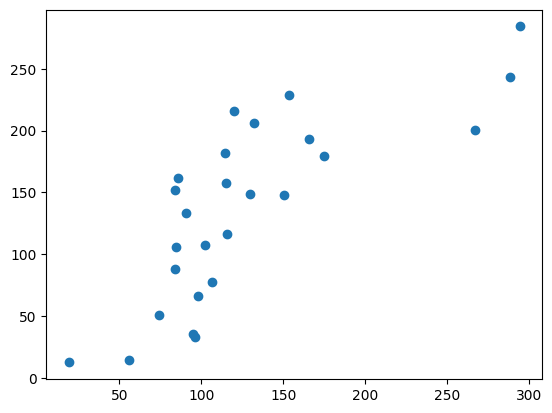

In [ ]:
# plt.scatter(X_train['rec_yds'], y_train)
plt.scatter(y_pred,y_test['next_yr_pts'])
plt.show()